<https://github.com/PolymathicAI/xVal>


In [1]:
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"

In [2]:
import jax.numpy as jnp  # Oddly works in colab to set gpu

arr = jnp.array([1, 2, 3])
arr.devices()

{cuda(id=0)}

In [3]:
import icecream
from icecream import ic

icecream.install()
ic_disable = False
if ic_disable:
    ic.disable()
ic.configureOutput(includeContext=True, contextAbsPath=True)

In [4]:
import os
import ast

from datetime import datetime as dt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
import hephaestus as hp
import jax
import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
from flax.training import train_state
from icecream import ic
from jax import random
from flax import struct
from flax.training import checkpoints
from jax.tree_util import tree_flatten
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm, trange
from hephaestus.models.simple_time_series import SimpleDS

pd.options.mode.copy_on_write = True

2024-06-12 04:29:27.974592: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
def line2df(line, idx):
    data_rows = []
    line = ast.literal_eval(line)
    for i, time_step in enumerate(line["data"]):
        row = {"time_step": i}
        # Add position data for each planet
        for j, position in enumerate(time_step):
            row[f"planet{j}_x"] = position[0]
            row[f"planet{j}_y"] = position[1]
        data_rows.append(row)

    df = pd.DataFrame(data_rows)
    description = line.pop("description")
    step_size = description.pop("stepsize")
    for k, v in description.items():
        for k_prop, v_prop in v.items():
            df[f"{k}_{k_prop}"] = v_prop
    df["time_step"] = df["time_step"] * step_size
    df.insert(0, "idx", idx)

    return df

In [6]:
files = os.listdir("data")
if "planets.parquet" not in files:
    with open("data/planets.data") as f:
        data = f.read().splitlines()

        dfs = []
        for idx, line in enumerate(tqdm(data)):
            dfs.append(line2df(line, idx))
        print("Concatenating dfs...")
        df = pd.concat(dfs)
    df.to_parquet("data/planets.parquet")
else:
    df = pd.read_parquet("data/planets.parquet")

In [7]:
# Get train test split at 80/20
train_idx = int(df.idx.max() * 0.8)
train_df = df.loc[df.idx < train_idx].copy()
test_df = df.loc[df.idx >= train_idx].copy()
# del df
train_ds = SimpleDS(train_df)
test_ds = SimpleDS(test_df)
len(train_ds), len(test_ds)

(99999, 25001)

In [8]:
test_df

,idx,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,0,0.000000,-0.274094,1.658928,-1.598680,1.237278,-0.072378,1.334127,3.092371,1.67039,...,-0.819635,-0.591357,3.125578,1.0,0.265969,NaN,NaN,NaN,NaN,NaN
1,0,0.733333,-0.810119,1.516448,-1.860540,0.797326,-0.675005,1.164327,3.092371,1.67039,...,-0.221462,-0.977945,3.125578,1.0,0.265969,NaN,NaN,NaN,NaN,NaN
2,0,1.466667,-1.261577,1.214381,-2.002381,0.305935,-1.131812,0.742120,3.092371,1.67039,...,0.488067,-0.865076,3.125578,1.0,0.265969,NaN,NaN,NaN,NaN,NaN
3,0,2.200000,-1.587840,0.791168,-2.015313,-0.205141,-1.347517,0.161522,3.092371,1.67039,...,0.940597,-0.299916,3.125578,1.0,0.265969,NaN,NaN,NaN,NaN,NaN
4,0,2.933333,-1.762252,0.291976,-1.898518,-0.702988,-1.278262,-0.453284,3.092371,1.67039,...,0.892142,0.424392,3.125578,1.0,0.265969,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,25000,18.139535,0.859903,-0.357431,-1.780663,-0.841087,NaN,NaN,2.983244,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,25000,18.604651,0.917215,0.133881,-1.609198,-1.111904,NaN,NaN,2.983244,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,25000,19.069767,0.732278,0.590216,-1.391311,-1.350590,NaN,NaN,2.983244,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,25000,19.534884,0.360838,0.898121,-1.132250,-1.549225,NaN,NaN,2.983244,1.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
test_df.shape, train_df.shape

((1110975, 27), (4452982, 27))

In [10]:
df.idx.max()

124999

In [11]:
def make_batch(ds: SimpleDS, start: int, length: int):
    data = []
    for i in range(start, length + start):
        data.append(ds[i])

    return jnp.array(data)


batch = make_batch(train_ds, 0, 4)

In [12]:
# time_series_regressor = hp.simple_time_series.SimplePred(
#     train_ds, d_model=2048, n_heads=16 # large
# )
multiplier = 4
time_series_regressor = hp.simple_time_series.SimplePred(
    train_ds, d_model=128 * multiplier**2, n_heads=8 * multiplier
)

In [13]:
key = random.PRNGKey(0)
init_key, dropout_key = random.split(key)
vars = time_series_regressor.init(
    {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
)
dropout_key, original_dropout_key = random.split(dropout_key)

ic| simple_time_series.py:167 in __call__()
    mask.shape: (4, 26, 1, 59, 59)
ic| simple_time_series.py:177 in __call__()
    col_embeddings.shape: (26, 2048)
    numeric_inputs.shape: (4, 26, 59)
ic| simple_time_series.py:181 in __call__()
    "before swap": 'before swap'
    repeated_numeric_indices.shape: (59, 26)
ic| simple_time_series.py:184 in __call__()
    "after swap": 'after swap'
    repeated_numeric_indices.shape: (26, 59)
ic| simple_time_series.py:186 in __call__()
    "Embedding!!": 'Embedding!!'
    numeric_col_embeddings.shape: (26, 59, 2048)
ic| simple_time_series.py:192 in __call__()
    "Re-tiling": 'Re-tiling'
    numeric_col_embeddings.shape: (4, 26, 59, 2048)
ic| simple_time_series.py:203 in __call__()
    "Before where": 'Before where'
    numeric_broadcast.shape: (4, 26, 59, 2048)
    nan_mask.shape: (4, 26, 59)
ic| simple_time_series.py:217 in __call__()
    "Before Positional Encoding": 'Before Positional Encoding'
    numeric_broadcast.shape: (4, 26, 59, 204

```
mask.shape=(4, 26, 1, 59, 59), attn_weights.shape=(4, 26, 16, 59, 59)
Mask example
[[0\. 0\. 0\. ... 0\. 0\. 0.]
 [0\. 1\. 0\. ... 0\. 0\. 0.]
 [0\. 1\. 1\. ... 0\. 0\. 0.]
 ...
 [1\. 1\. 1\. ... 1\. 0\. 0.]
 [1\. 1\. 1\. ... 1\. 1\. 0.]
 [1\. 1\. 1\. ... 1\. 1\. 1.]]
```


In [14]:
ic.disable()

In [15]:
x = time_series_regressor.apply(
    vars, batch, deterministic=False, rngs={"dropout": dropout_key}
)
x.shape

(4, 26, 59)

In [16]:
time_series_regressor.tabulate(
    {"params": init_key, "dropout": dropout_key},
    batch,
    console_kwargs={"force_jupyter": True, "width": 120},
)

                                                   SimplePred Summary                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path                  ┃ module                ┃ inputs                ┃ outputs              ┃ params                ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━┩
│                       │ SimplePred            │ float32[4,26,59]      │ float32[4,26,59]     │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ TimeSeriesTransformer │ deterministic: False  │ float32[4,26,59,204… │                       │
│                       │                       │ mask_data: True       │                      │                       │
│                       │                       │ numeric_inputs:       │                      │                       │
│                       │                       │ float32[4,26,59]      │                      │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ Embed                 │ int32[26]             │ float32[26,2048]     │ embedding:            │
│                       │                       │                       │                      │ float32[30,2048]      │
│                       │                       │                       │                      │                       │
│                       │                       │                       │                      │ 61,440 (245.8 KB)     │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ PositionalEncoding    │ float32[4,26,59,2048] │ float32[4,26,59,204… │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ TransformerBlock      │ deterministic: False  │ float32[4,26,59,204… │                       │
│                       │                       │ k:                    │                      │                       │
│                       │                       │ float32[4,26,59,2048] │                      │                       │
│                       │                       │ mask:                 │                      │                       │
│                       │                       │ float32[4,26,1,59,59] │                      │                       │
│                       │                       │ q:                    │                      │                       │
│                       │                       │ float32[4,26,59,2048] │                      │                       │
│                       │                       │ v:                    │                      │                       │
│                       │                       │ float32[4,26,59,2048] │                      │                       │
├───────────────────────┼───────────────────────┼───────────────────────┼──────────────────────┼───────────────────────┤
│ TimeSeriesTransforme… │ MultiHeadDotProductA… │ -                     │ float32[4,26,59,204… │                       │
│                       │                       │ float32[4,26,59,2048] │                      │                       │
│                       │                       │ -                     │                      │                       │
│                       │                       │ float32[4,26,59,2048] │                      │                       │
│                       │                       │ -                     │                      │                       │
│      

'\n\n'

In [17]:
def calculate_memory_footprint(params):
    """Calculate total memory footprint of JAX model parameters and total
    number of parameters."""
    total_bytes = 0
    # Flatten the parameter tree structure into a list of arrays
    flat_params, _ = tree_flatten(params)
    for param in flat_params:
        # Calculate bytes: number of elements * size of each element
        bytes_per_param = param.size * param.dtype.itemsize
        total_bytes += bytes_per_param
    return total_bytes


def count_parameters(params):
    return sum(jnp.prod(jnp.array(p.shape)) for p in jax.tree_util.tree_leaves(params))


mem = calculate_memory_footprint(vars)
total_params = count_parameters(vars)


print(f"Memory of custom: {mem / 1e6:.2f} MB with {total_params:,} parameters")

Memory of custom: 306.76 MB with 76,689,665 parameters


In [18]:
mts_root_key = random.PRNGKey(44)
mts_main_key, ts_params_key, ts_data_key = random.split(mts_root_key, 3)

mask_data = False


def clip_gradients(gradients, max_norm):
    total_norm = jnp.sqrt(sum(jnp.sum(jnp.square(grad)) for grad in gradients.values()))
    scale = max_norm / (total_norm + 1e-6)
    clipped_gradients = jax.tree_map(
        lambda grad: jnp.where(total_norm > max_norm, grad * scale, grad), gradients
    )
    return clipped_gradients


def base_loss(inputs, outputs):
    # Remove the first value and add a jnp.nan to the end
    # inputs = inputs * 3
    inputs_offset = 1
    inputs = inputs[:, :, inputs_offset:]
    print(f"Inputs shape: {inputs.shape=}")
    # Add a jnp.nan to the end
    temp_null = jnp.full((inputs.shape[0], inputs.shape[1], inputs_offset), jnp.nan)
    inputs = jnp.concatenate(
        [inputs, temp_null],
        axis=2,
    )
    print(f"Inputs shape after addition: {inputs.shape=}")
    nan_mask = jnp.isnan(inputs)
    inputs = jnp.where(nan_mask, jnp.zeros_like(inputs), inputs)

    # outputs = outputs[:, :, :-inputs_offset]
    outputs = jnp.where(nan_mask, jnp.zeros_like(outputs), outputs)

    # raw_loss = optax.squared_error(outputs, inputs)
    # compute manually
    raw_loss = jnp.square(outputs - inputs)
    masked_loss = jnp.where(nan_mask, 0.0, raw_loss)
    loss = masked_loss.sum() / (~nan_mask).sum()

    return loss


def calculate_loss(params, state, inputs, dropout_key, mask_data: bool = True):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        rngs={"dropout": dropout_key},
        deterministic=False,
        mask_data=mask_data,
    )
    loss = base_loss(inputs, outputs)
    # Create mask for nan inputs

    return loss


@jax.jit
def train_step(state: train_state.TrainState, batch, base_key, mask_data=True):
    dropout_key, mask_key, new_key = jax.random.split(base_key, 3)

    def calculate_loss_with_mask(params):
        return calculate_loss(params, state, batch, dropout_key, mask_data=True)

    def calculate_loss_without_mask(params):
        return calculate_loss(params, state, batch, dropout_key, mask_data=False)

    def loss_fn(params):
        return jax.lax.cond(
            mask_data,
            lambda _: calculate_loss_with_mask(params),
            lambda _: calculate_loss_without_mask(params),
            operand=None,
        )

    # def loss_fn(params):
    #     return calculate_loss(params, state, batch, dropout_key, mask_data=mask_data)

    grad_fn = jax.value_and_grad(loss_fn)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss, grad = grad_fn(state.params)
    # grad = replace_nans(grad)
    # grad = clip_gradients(grad, 1.0)
    state = state.apply_gradients(grads=grad)

    return state, loss, new_key


def evaluate(params, state, inputs, mask_data: bool = True):
    outputs = state.apply_fn(
        {"params": params},
        # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
        inputs,
        deterministic=True,
        mask_data=mask_data,
    )
    loss = base_loss(inputs, outputs)
    return loss


@jax.jit
def eval_step(state: train_state.TrainState, batch, base_key, mask_data=True):
    mask_key, dropout_key, new_key = jax.random.split(base_key, 3)

    def calculate_loss_with_mask(params):
        return calculate_loss(params, state, batch, dropout_key, mask_data=True)

    def calculate_loss_without_mask(params):
        return calculate_loss(params, state, batch, dropout_key, mask_data=False)

    def loss_fn(params):
        return jax.lax.cond(
            mask_data,
            lambda _: calculate_loss_with_mask(params),
            lambda _: calculate_loss_without_mask(params),
            operand=None,
        )

    # def loss_fn(params):
    #     return evaluate(params, state, batch, mask_data=mask_data)

    # (loss, individual_losses), grad = grad_fn(state.params)
    loss = loss_fn(state.params)
    return loss, new_key


def create_train_state(model, prng, batch, lr):
    init_key, dropout_key = random.split(prng)
    params = model.init(
        {"params": init_key, "dropout": dropout_key}, batch, deterministic=False
    )
    # optimizer = optax.chain(optax.adam(lr))
    optimizer = optax.chain(optax.clip_by_global_norm(0.4), optax.adam(lr))
    # optimizer_state = optimizer.init(params)
    return train_state.TrainState.create(
        apply_fn=model.apply,
        params=params["params"],
        tx=optimizer,
        # tx_state=optimizer_state,
    )


batch_size = 2
# batch = train_ds[0]
# state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)
state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)

In [20]:
writer_name = "MoreBlocksSlightlySmaller"

writer_time = dt.now().strftime("%Y-%m-%dT%H:%M:%S")
model_name = writer_time + writer_name
train_summary_writer = SummaryWriter("runs/" + model_name)

MASK_DATA = True

test_set_key = random.PRNGKey(4454)

batch_size = 32
train_data_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# train_data_loader = DataLoader(train_ds, batch_size=256 // 2, shuffle=True)
# test_data_loader = DataLoader(test_ds, batch_size=256 // 2, shuffle=True)

batch_count = 0
base_key = random.PRNGKey(42)

# Disable IC for training
ic.disable()
for j in trange(3, desc=f"epochs for {train_summary_writer.log_dir}"):
    # arrs = train_data_loader()
    for i in tqdm(train_data_loader, leave=False, desc="batches"):
        # for i in trange(len(pre_train) // batch_size, leave=False):
        # for i in trange(len(pre_train) // batch_size //10, leave=False):
        # batch = make_batch(train_ds, i[0], 4)

        state, loss, base_key = train_step(
            state, jnp.array(i), base_key, mask_data=MASK_DATA
        )
        if jnp.isnan(loss):
            raise ValueError("Nan Value in loss, stopping")
        batch_count += 1

        if batch_count % 1 == 0:
            train_summary_writer.add_scalar(
                "loss/loss", np.array(loss.item()), batch_count
            )
        if batch_count % 10 == 0:
            test_loss, base_key = eval_step(
                state,
                jnp.array(next(iter(test_data_loader))),
                base_key,
                mask_data=MASK_DATA,
            )
            train_summary_writer.add_scalar(
                "loss/test_loss", np.array(test_loss.item()), batch_count
            )
            train_summary_writer.flush()
        # if batch_count > 200:
        #     break

train_summary_writer.close()

epochs for runs/2024-06-12T04:30:53MoreBlocksSlightlySmaller:   0%|          | 0/3 [00:00<?, ?it/s]

batches:   0%|          | 0/1563 [00:00<?, ?it/s]

Inputs shape: inputs.shape=(64, 26, 58)
Inputs shape after addition: inputs.shape=(64, 26, 59)
Inputs shape: inputs.shape=(64, 26, 58)
Inputs shape after addition: inputs.shape=(64, 26, 59)


2024-06-12 04:31:16.479462: W external/xla/xla/service/hlo_rematerialization.cc:2941] Can't reduce memory use below 18.21GiB (19555813162 bytes) by rematerialization; only reduced to 63.06GiB (67707164012 bytes), down from 63.39GiB (68067845808 bytes) originally
2024-06-12 04:31:30.322688: W external/tsl/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 54.71GiB (rounded to 58746284288)requested by op 
2024-06-12 04:31:30.323201: W external/tsl/tsl/framework/bfc_allocator.cc:494] ***************_____________________________________________________________________________________
E0612 04:31:30.325050   23173 pjrt_stream_executor_client.cc:2804] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 58746284232 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  878.02MiB
              constant allocation:     8.4KiB
        maybe_live_out allocation:  877.64MiB

XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 58746284232 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  878.02MiB
              constant allocation:     8.4KiB
        maybe_live_out allocation:  877.64MiB
     preallocated temp allocation:   54.71GiB
                 total allocation:   56.43GiB
Peak buffers:
	Buffer 1:
		Size: 1.50GiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/RegressionOutputChain/jit(relu)/max" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/combinators.py" source_line=112 deduplicated_name="input_compare_maximum_reduce_fusion"
		XLA Label: fusion
		Shape: f32[98176,4096]
		==========================

	Buffer 2:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_1/MultiHeadDotProductAttention_0/value/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=207 deduplicated_name="input_transpose_fusion.4"
		XLA Label: fusion
		Shape: f32[64,26,32,64,59]
		==========================

	Buffer 3:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_1/MultiHeadDotProductAttention_0/key/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=207 deduplicated_name="input_transpose_fusion.4"
		XLA Label: fusion
		Shape: f32[64,26,32,64,59]
		==========================

	Buffer 4:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_1/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 5:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_1/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 6:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_1/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 7:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_1/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 8:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_0/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 9:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_0/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 10:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_0/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 11:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/LayerNorm_0/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/normalization.py" source_line=209 deduplicated_name="loop_add_multiply_subtract_fusion"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================

	Buffer 12:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/MultiHeadDotProductAttention_0/...hqk,...khd->...qhd/dot_general[dimension_numbers=(((2,), (4,)), ((0, 1, 3), (0, 1, 2))) precision=None preferred_element_type=float32]" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/attention.py" source_line=237
		XLA Label: custom-call
		Shape: f32[53248,64,59]
		==========================

	Buffer 13:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/MultiHeadDotProductAttention_0/value/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=207 deduplicated_name="input_transpose_fusion.4"
		XLA Label: fusion
		Shape: f32[64,26,32,64,59]
		==========================

	Buffer 14:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/TransformerBlock_0/MultiHeadDotProductAttention_0/key/add" source_file="/home/ubuntu/environment/Hephaestus/.venv/lib/python3.10/site-packages/flax/linen/linear.py" source_line=207 deduplicated_name="input_transpose_fusion.4"
		XLA Label: fusion
		Shape: f32[64,26,32,64,59]
		==========================

	Buffer 15:
		Size: 767.00MiB
		Operator: op_name="jit(train_step)/jit(main)/jvp(cond)/branch_0_fun/SimplePred/TimeSeriesTransformer_0/reshape[new_sizes=(64, 26, 59, 2048) dimensions=None]" source_file="/home/ubuntu/environment/Hephaestus/hephaestus/models/simple_time_series.py" source_line=188 deduplicated_name="loop_broadcast_fusion.24"
		XLA Label: fusion
		Shape: f32[64,26,59,2048]
		==========================



In [ ]:
import shutil
from flax import struct, serialization
import orbax.checkpoint
import optax
from flax.training import orbax_utils

# Save the model
ckpt_dir = f"ckpts/{model_name}/"
# make absolute path
ckpt_dir = os.path.abspath(ckpt_dir)

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)

ckpt = {"state": state, "step": batch_count}
# Save to disk
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(ckpt)
orbax_checkpointer.save(ckpt_dir, ckpt, save_args=save_args)

new_state = create_train_state(time_series_regressor, mts_main_key, batch, 0.0001)
# Load from disk
ckpt1 = orbax_checkpointer.restore(ckpt_dir)
new_state = new_state.replace(params=ckpt1["state"]["params"])

In [ ]:
# import orbax
# from flax.training import orbax_utils

# ckpts_dir = "ckpts"
# absolute_ckpts_dir = os.path.abspath(os.path.join(ckpts_dir, model_name))

# ckpt = {"state": state, "batch_count": batch_count}

# orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
# save_args = orbax_utils.save_args_from_target(ckpt)
# orbax_checkpointer.save(absolute_ckpts_dir, ckpt, save_args=save_args, force=True)

In [ ]:
def return_results(state, dataset, idx=0, mask_start: int = None):
    inputs = dataset[idx]
    if mask_start:
        inputs = inputs[:, :mask_start]
    inputs = jnp.array([inputs])
    outputs = state.apply_fn(
        {"params": state.params},
        # hp.mask_tensor(jnp.array([train_ds[0]]), dataset, prng_key=key),
        inputs,
        deterministic=True,
        mask_data=MASK_DATA,
    )
    return outputs, inputs

In [ ]:
def show_results_df(state, base_df, dataset, idx: int = 0, mask_start: int = None):
    outputs, inputs = return_results(state, dataset, idx=idx, mask_start=mask_start)

    outputs = jnp.squeeze(outputs)
    df_pred = pd.DataFrame(outputs.T)
    df_pred.columns = base_df.columns[1:]

    inputs = jnp.squeeze(inputs)
    df_actual_masked = pd.DataFrame(inputs.T)
    df_actual_masked.columns = base_df.columns[1:]
    # remove the first row to match the prediction
    # df_actual_masked = df_actual_masked.iloc[1:].reset_index()
    diff_df = df_pred - df_actual_masked

    inputs_no_mask = jnp.array([dataset[idx]])
    df_no_mask = pd.DataFrame(jnp.squeeze(inputs_no_mask).T)
    df_no_mask.columns = base_df.columns[1:]
    # df_no_mask = df_no_mask.iloc[1:].reset_index()  # rm first row
    diff_df_no_mask = df_pred - df_no_mask
    return {
        "pred": df_pred,
        "actual_masked": df_actual_masked,
        "actual_no_mask": df_no_mask,
        "diff_masked": diff_df,
        "diff_no_mask": diff_df_no_mask,
    }


res = show_results_df(new_state, train_df, train_ds, idx=0, mask_start=10)

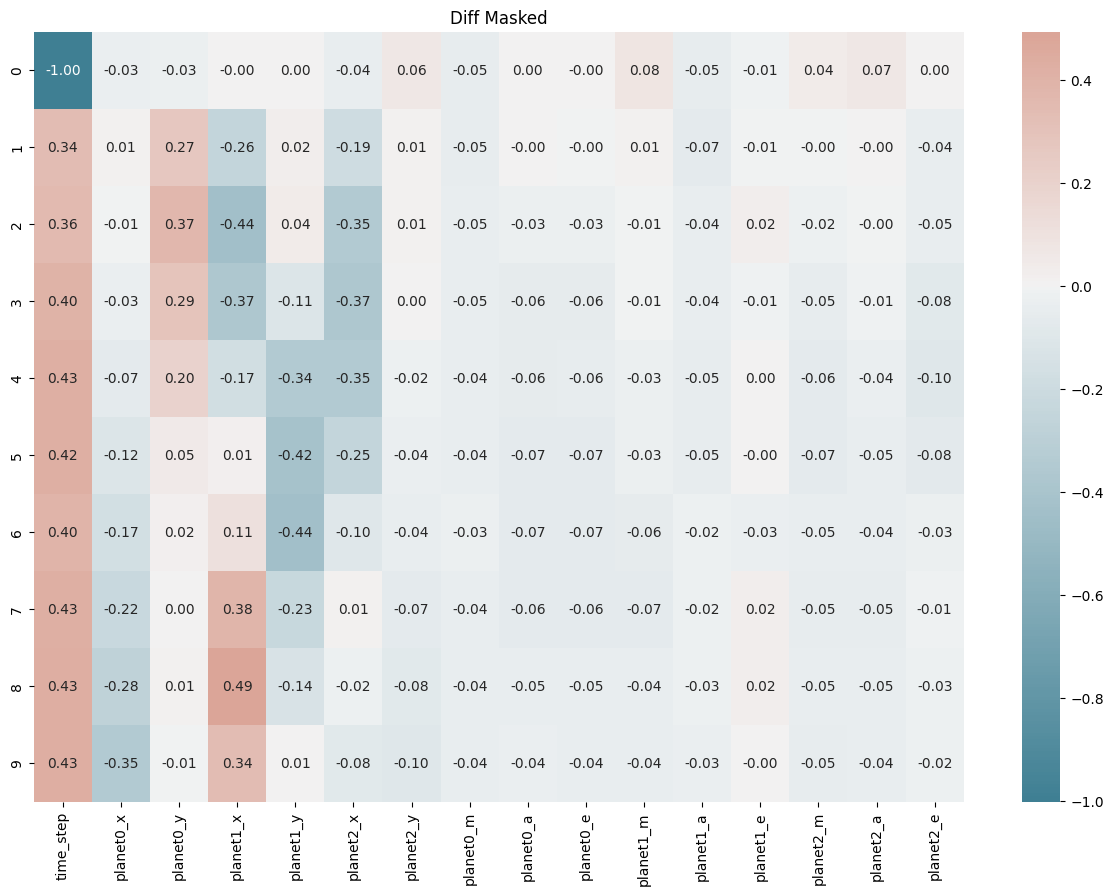

In [ ]:
def show_heatmap(df, title):
    """Shows heatmap for a dataframe
    excludes all columns that are only nan and all rows that are only nan"""

    df = df.dropna(axis=1, how="all")
    df = df.dropna(axis=0, how="all")
    plt.figure(figsize=(15, 10))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(df, cmap=cmap, center=0, annot=True, fmt=".2f")
    plt.title(title)
    plt.show()


show_heatmap(res["diff_masked"], "Diff Masked")

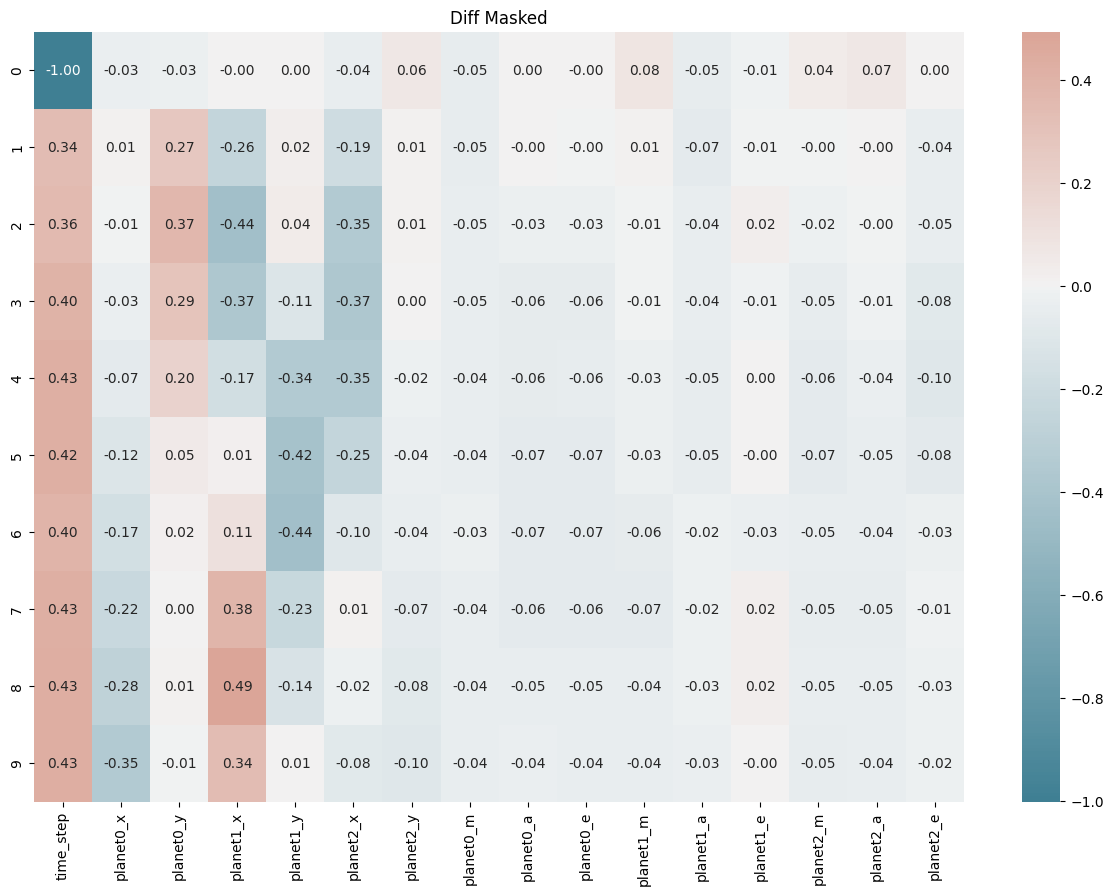

In [ ]:
show_heatmap(res["diff_no_mask"].head(14), "Diff Masked")

In [ ]:
test_key = random.PRNGKey(4454)
x = jax.random.normal(test_key, (4, 26, 59, 256))

In [ ]:
no_mask_out = state.apply_fn(
    {"params": state.params},
    # jnp.array([test_ds[0][:10, :]]),
    jnp.array([test_ds[0][:, :10]]),
    deterministic=True,
    mask_data=True,
)
mask_out = state.apply_fn(
    {"params": state.params},
    jnp.array([test_ds[0][:, :20]]),
    deterministic=True,
    mask_data=True,
)
mask_out_df = pd.DataFrame(jnp.squeeze(mask_out).T)
mask_out_df.columns = test_df.columns[1:]
no_mask_out_df = pd.DataFrame(jnp.squeeze(no_mask_out).T)
no_mask_out_df.columns = test_df.columns[1:]

test_diff = mask_out_df - no_mask_out_df
test_diff

,time_step,planet0_x,planet0_y,planet1_x,planet1_y,planet2_x,planet2_y,planet0_m,planet0_a,planet0_e,...,planet3_x,planet3_y,planet3_m,planet3_a,planet3_e,planet4_x,planet4_y,planet4_m,planet4_a,planet4_e
0,0.677229,-0.000206,-0.000772,-0.000251,-0.000444,-0.000463,-0.000268,-0.000394,-0.000504,-0.000083,...,-0.000610,-0.000135,-0.000409,-0.000348,-0.000505,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010
1,-0.000319,-0.000769,-0.000338,0.000123,-0.000261,0.000044,-0.000597,-0.000829,-0.000608,-0.000142,...,-0.000309,0.000153,-0.000283,-0.000507,-0.000248,-0.000519,-0.000519,-0.000519,-0.000519,-0.000519
2,-0.000721,-0.000536,-0.000143,-0.000054,-0.000063,-0.000420,-0.000366,-0.000493,0.000260,-0.000937,...,0.000025,-0.000193,-0.000277,-0.000071,-0.000355,-0.000092,-0.000092,-0.000092,-0.000092,-0.000092
3,0.000357,-0.000410,-0.000009,-0.000412,-0.000164,-0.000356,-0.000242,-0.000057,0.000434,0.000146,...,0.000113,-0.000555,0.000482,-0.000151,-0.000404,0.000185,0.000185,0.000185,0.000185,0.000185
4,-0.000439,-0.000122,-0.000166,0.000587,0.000174,-0.000337,-0.000395,-0.000347,0.000011,-0.000025,...,0.000511,-0.000451,0.000595,0.000019,0.000237,0.000171,0.000171,0.000171,0.000171,0.000171
5,-0.000428,0.000005,0.000022,-0.000363,-0.000080,0.000294,-0.000018,-0.000035,-0.000062,0.000105,...,-0.000377,-0.000538,-0.000448,-0.000102,-0.000268,-0.000216,-0.000216,-0.000216,-0.000216,-0.000216
6,-0.000138,0.000194,-0.000053,-0.000159,0.000440,-0.000230,0.000283,0.000180,0.000030,0.000048,...,-0.000300,-0.000353,0.000362,0.000369,-0.000027,0.000588,0.000588,0.000588,0.000588,0.000588
7,0.000056,-0.000156,0.000448,0.000124,-0.000058,0.000052,-0.000021,0.000433,0.000322,-0.000046,...,0.000014,-0.000287,-0.000101,0.000850,0.000168,-0.000010,-0.000010,-0.000010,-0.000010,-0.000010
8,0.000799,-0.000116,0.000444,-0.000095,0.000233,0.000091,-0.000075,-0.000412,-0.000037,0.000026,...,-0.000080,0.000416,0.000475,0.000105,-0.000056,-0.000011,-0.000011,-0.000011,-0.000011,-0.000011
9,0.000128,-0.000032,0.000659,0.000079,0.000274,0.000134,0.000228,0.000217,-0.000165,0.000204,...,0.000344,-0.000035,0.000082,0.000221,0.000569,0.000240,0.000240,0.000240,0.000240,0.000240


In [ ]:
def plot_planets(df_pred: pd.DataFrame, df_actual: pd.DataFrame, column: str, offset=0):
    plt.figure(figsize=(15, 10))
    plt.plot(df_pred[column], label="Auto")
    plt.plot(df_actual[column], label="Actual")
    plt.legend()
    # Show ticks and grid lines every 1 step
    plt.xticks(np.arange(0, len(df_pred), 1))
    plt.grid()
    # add black line at 0 on the y axis to show the difference
    plt.axhline(0, color="black")
    plt.show()

In [ ]:
def auto_regressive_predictions(
    state: train_state.TrainState, inputs: jnp.ndarray
) -> np.ndarray:
    # get the first row that contains all nan vales
    # if nan_rows_start >= stop_idx:
    #     return inputs
    nan_columns = jnp.isnan(inputs).all(axis=1)
    outputs = state.apply_fn(
        {"params": state.params},
        jnp.array([inputs]),
        # jnp.array([inputs]),
        deterministic=True,
        mask_data=MASK_DATA,
    )
    outputs = jnp.squeeze(outputs)
    final_row = np.array(outputs[:, -1])
    final_row = final_row[:, None]
    inputs = jnp.concatenate([inputs, final_row], axis=1)
    inputs = np.array(inputs)
    inputs[nan_columns] = np.nan
    return inputs
    # return auto_regressive_predictions(state, inputs, stop_idx)

In [ ]:
inputs = test_ds[0][:, :10]
print(inputs.shape)
for i in trange(21):
    inputs = auto_regressive_predictions(state, inputs)

# x = auto_regressive_predictions(state, test_ds[0], 10)

(26, 10)


  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
df_auto = pd.DataFrame(inputs.T)
df_actual = pd.DataFrame(test_ds[0].T)
df_auto.columns = train_df.columns[1:]
df_actual.columns = train_df.columns[1:]
df_diff = df_auto - df_actual

# Drop rows that are all nan
df_diff = df_diff.dropna(axis=0, how="all")

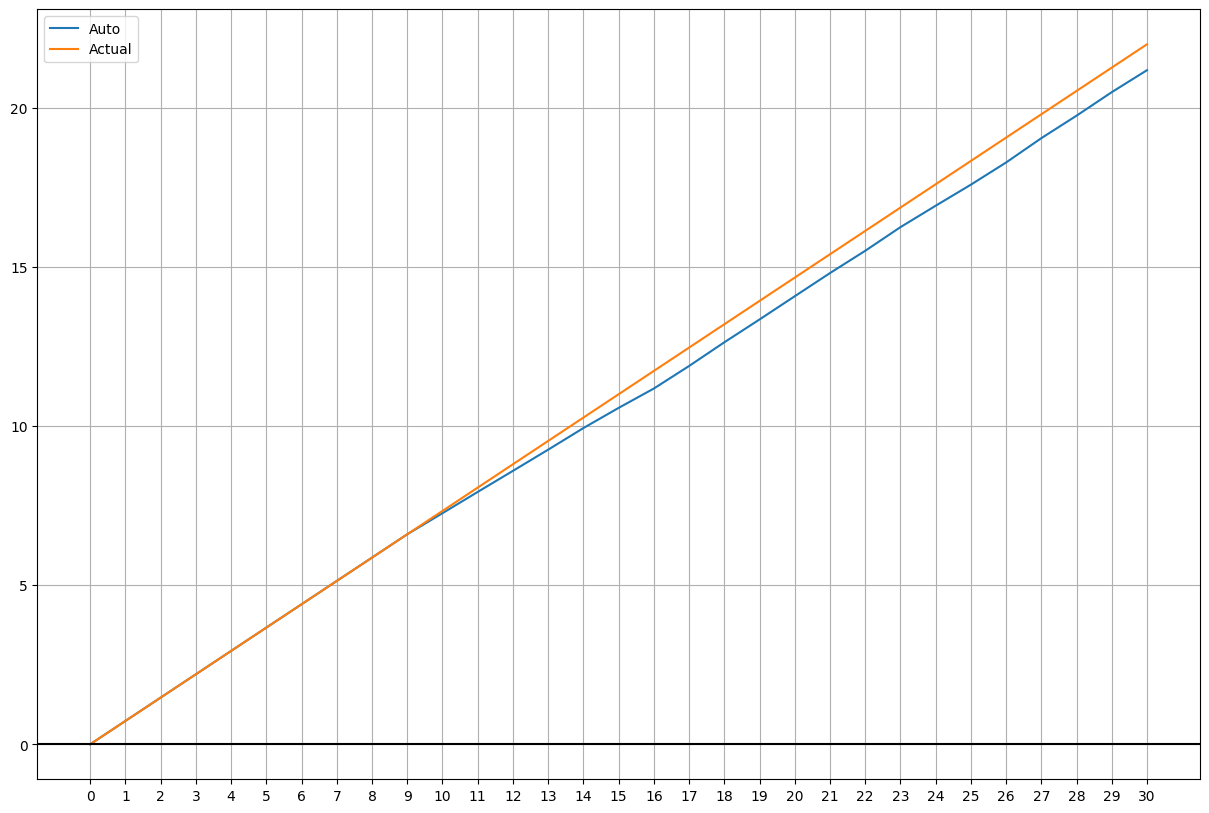

In [ ]:
plot_planets(df_auto, df_actual, "time_step")

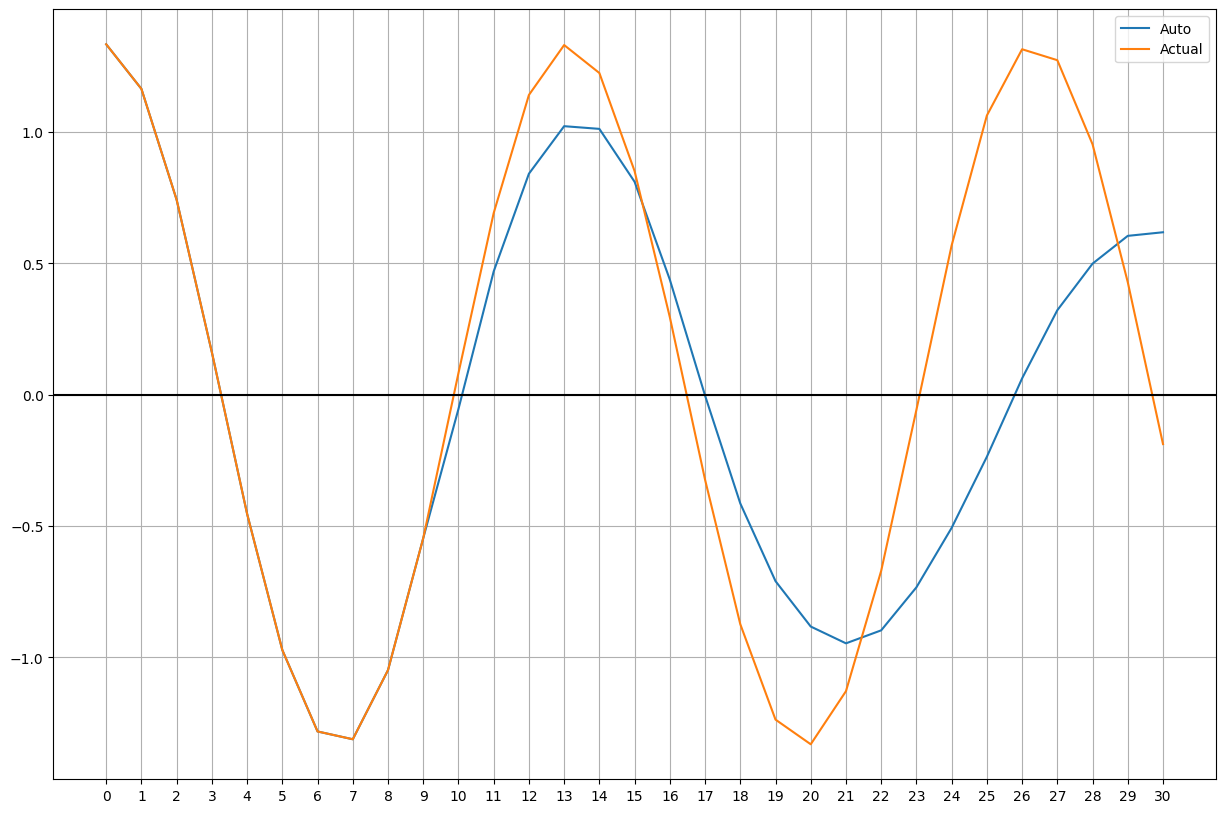

In [ ]:
plot_planets(df_auto, df_actual, "planet2_y")

Hi (1, 26, 59)
Inputs shape: inputs.shape=(1, 26, 59), Outputs shape: outputs.shape=(1, 26, 59)
Inputs shape: inputs.shape=(1, 26, 58)
Inputs shape after addition: inputs.shape=(1, 26, 59)


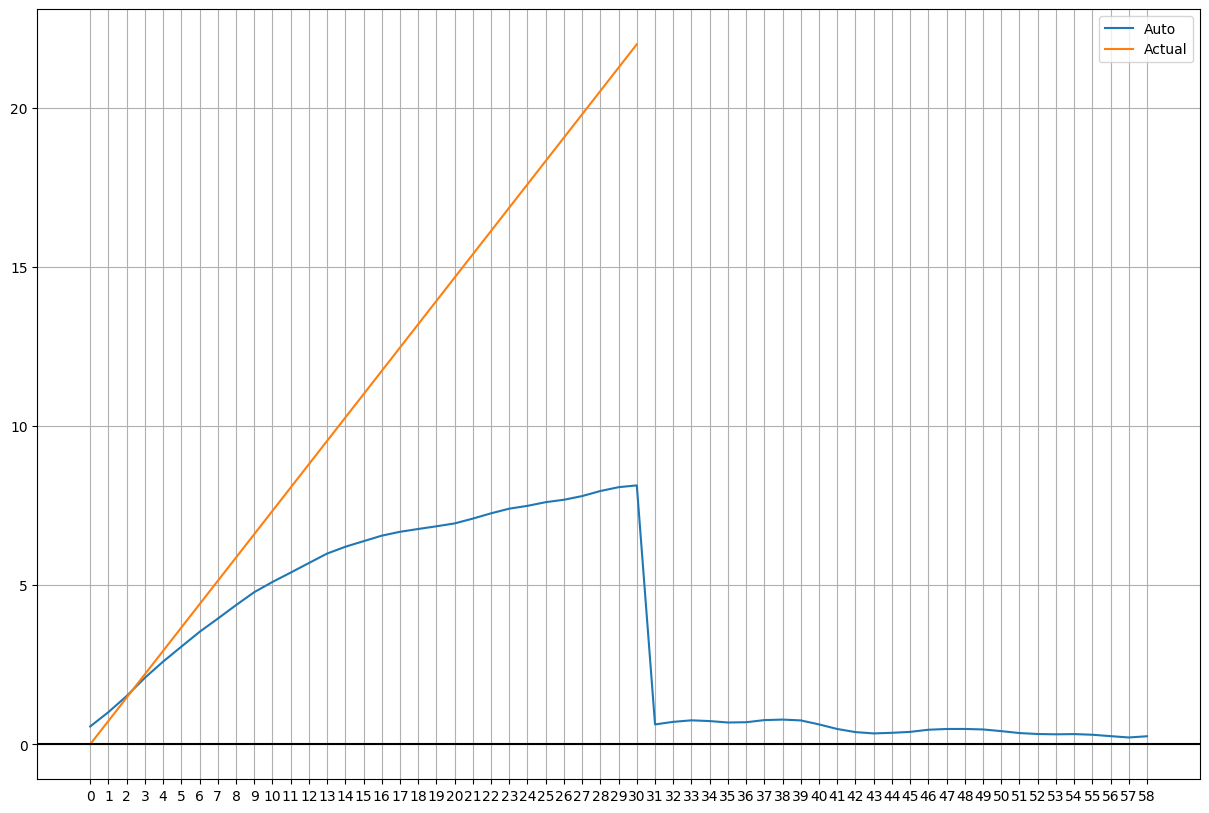

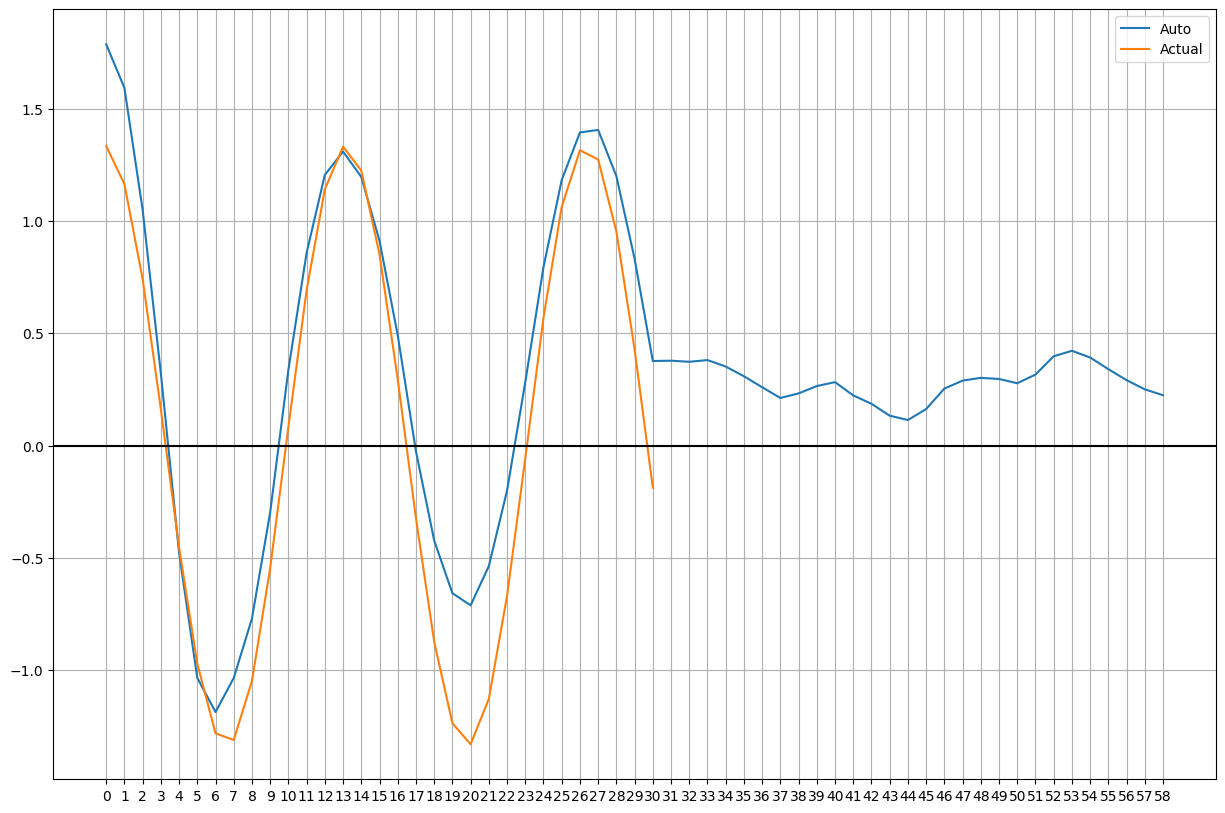

In [ ]:
# inputs = jnp.array(next(iter(test_data_loader)))
inputs = make_batch(test_ds, 0, 1)
print("Hi", inputs.shape)
# inputs = inputs[:, :, :50]
outputs = state.apply_fn(
    {"params": state.params},
    # hp.mask_tensor(inputs, dataset, prng_key=mask_key),
    inputs,
    deterministic=True,
    mask_data=False,
)
print(f"Inputs shape: {inputs.shape=}, Outputs shape: {outputs.shape=}")
base_loss(inputs, outputs)
df_actual = pd.DataFrame(jnp.squeeze(inputs).T)
df_actual.columns = test_df.columns[1:]

df_pred = pd.DataFrame(jnp.squeeze(outputs).T)
df_pred.columns = test_df.columns[1:]
plot_planets(df_pred, df_actual, "time_step")
plot_planets(df_pred, df_actual, "planet2_y")

In [ ]:
inputs.shape

(1, 26, 59)

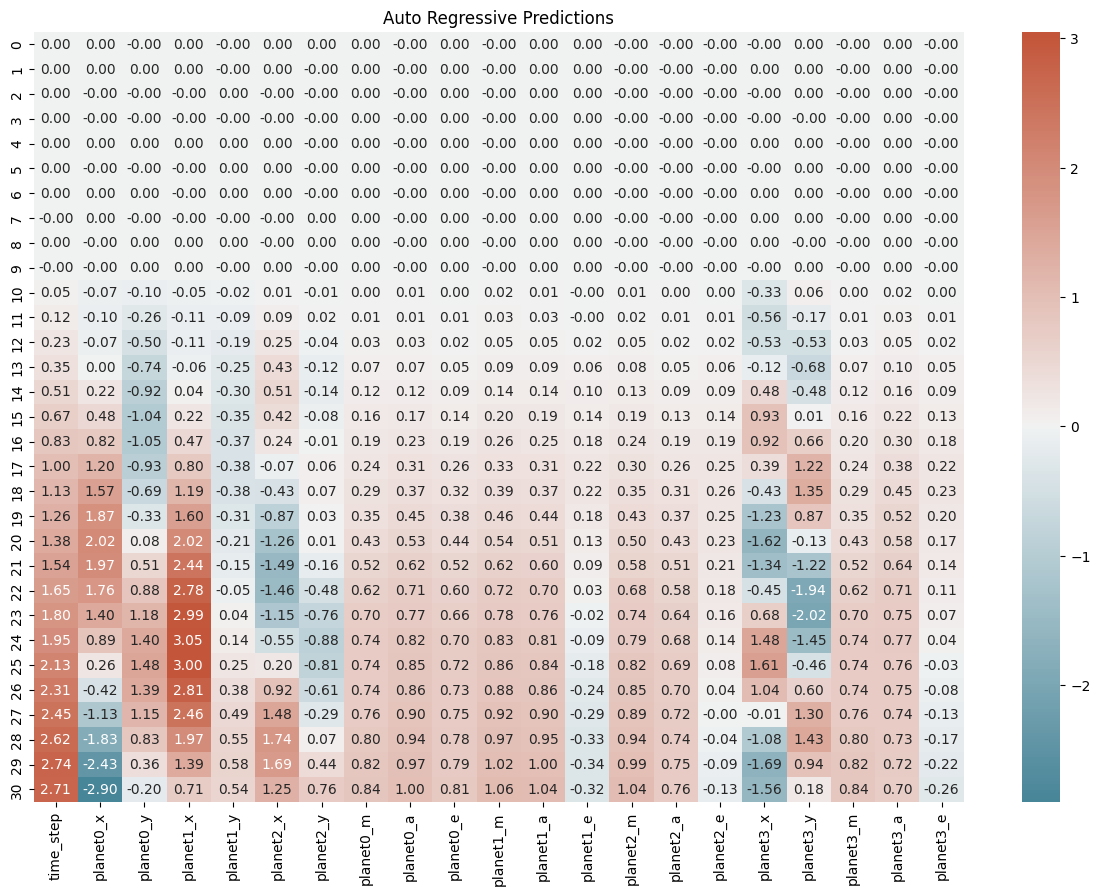

In [ ]:
show_heatmap(df_diff, "Auto Regressive Predictions")

In [ ]:
# plot planet0_x from df_auto and df_actual


res = show_results_df(state, train_df, train_ds, idx=299, mask_start=20)
plot_planets(res["pred"], res["actual_masked"], "planet2_y", offset=0)
# plot_planets(df_auto, df_actual, "planet2_y")

NameError: name 'show_results_df' is not defined

In [ ]:
# plot planet0_x from df_auto and df_actual
res = show_results_df(state, train_df, train_ds, idx=20, mask_start=20)
plot_planets(res["pred"], res["actual_no_mask"], "planet1_y", offset=0)

NameError: name 'show_results_df' is not defined

In [ ]:
res = show_results_df(state, train_df, test_ds, idx=0, mask_start=30)

plot_planets(res["pred"], res["actual_masked"], "planet2_x", offset=0)

NameError: name 'show_results_df' is not defined

In [ ]:
loss, key = eval_step(state, jnp.array(next(iter(test_data_loader))), base_key)
loss, key

Inputs shape: inputs.shape=(32, 26, 58)
Inputs shape after addition: inputs.shape=(32, 26, 59)
Inputs shape: inputs.shape=(32, 26, 58)
Inputs shape after addition: inputs.shape=(32, 26, 59)


(Array(0.00421745, dtype=float32),
 Array([1912569553, 4269841867], dtype=uint32))